In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv("D:/HocMay/archive_bt/Mental_Health_dataset.csv")

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261328 entries, 0 to 261327
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Gender                 261328 non-null  object
 1   Country                261328 non-null  object
 2   Occupation             261328 non-null  object
 3   SelfEmployed           256972 non-null  object
 4   FamilyHistory          261328 non-null  object
 5   Treatment              261328 non-null  object
 6   DaysIndoors            261328 non-null  object
 7   HabitsChange           261328 non-null  object
 8   MentalHealthHistory    261328 non-null  object
 9   IncreasingStress       261328 non-null  object
 10  MoodSwings             261328 non-null  object
 11  SocialWeakness         261328 non-null  object
 12  CopingStruggles        261328 non-null  object
 13  WorkInterest           261328 non-null  object
 14  SocialWeakness.1       261328 non-null  object
 15  

,Gender,Country,Occupation,SelfEmployed,FamilyHistory,Treatment,DaysIndoors,HabitsChange,MentalHealthHistory,IncreasingStress,MoodSwings,SocialWeakness,CopingStruggles,WorkInterest,SocialWeakness.1,MentalHealthInterview,CareOptions
0,Female,UK,Others,No,Yes,No,15-30 days,No,Yes,Yes,High,No,Yes,Maybe,No,No,No
1,Female,USA,Housewife,No,Yes,No,15-30 days,Maybe,Maybe,Yes,High,Maybe,Yes,Maybe,Maybe,No,Not sure
2,Female,Canada,Others,No,No,Yes,More than 2 months,Maybe,No,No,Medium,No,No,No,No,No,Not sure
3,Female,Canada,Corporate,No,Yes,Yes,Go out Every day,No,Maybe,No,Medium,No,No,Maybe,No,No,Not sure
4,Female,UK,Corporate,No,No,Yes,More than 2 months,Yes,No,Maybe,Medium,Maybe,No,Maybe,Maybe,No,Not sure
5,Female,USA,Student,No,No,No,Go out Every day,Yes,Yes,Yes,High,Maybe,No,No,Maybe,No,Not sure
6,Female,USA,Corporate,No,Yes,No,1-14 days,Yes,Maybe,Maybe,High,No,Yes,No,No,No,No
7,Female,USA,Housewife,No,Yes,Yes,15-30 days,Yes,Yes,Yes,Medium,Maybe,Yes,Maybe,Maybe,No,No
8,Female,USA,Student,No,Yes,Yes,Go out Every day,Yes,Maybe,Yes,Medium,Maybe,Yes,No,Maybe,No,Yes
9,Female,USA,Housewife,No,Yes,Yes,1-14 days,Yes,Yes,Yes,Medium,Maybe,Yes,No,Maybe,No,Not sure


Mô tả dữ liệu sử dụng:

-Quy mô: 261,328 mẫu, 17 cột.

-Kiểu dữ liệu: 100% là categorical (object).

-Bộ nhớ: ~34 MB.

Thuộc tính chính:

-Thông tin cá nhân – xã hội: Gender, Country, Occupation, SelfEmployed.

-Tiền sử và trạng thái sức khỏe tâm thần: FamilyHistory, MentalHealthHistory, IncreasingStress, MoodSwings.

-Hành vi và cảm xúc: DaysIndoors, HabitsChange, SocialWeakness, CopingStruggles, WorkInterest.

-Tiếp cận chăm sóc và phỏng vấn: MentalHealthInterview, CareOptions.

-Biến mục tiêu: Treatment (Yes/No – cần hay không cần điều trị).

In [3]:
df.describe()

,Gender,Country,Occupation,SelfEmployed,FamilyHistory,Treatment,DaysIndoors,HabitsChange,MentalHealthHistory,IncreasingStress,MoodSwings,SocialWeakness,CopingStruggles,WorkInterest,SocialWeakness.1,MentalHealthInterview,CareOptions
count,261328,261328,261328,256972,261328,261328,261328,261328,261328,261328,261328,261328,261328,261328,261328,261328,261328
unique,2,35,5,2,2,2,5,3,3,3,3,3,2,3,3,3,3
top,Male,USA,Housewife,No,No,No,1-14 days,Yes,No,Maybe,Medium,Maybe,No,No,Maybe,No,No
freq,230614,154478,60081,230404,161981,132958,57598,97687,94027,90697,90215,93271,139251,94460,93271,205477,108972


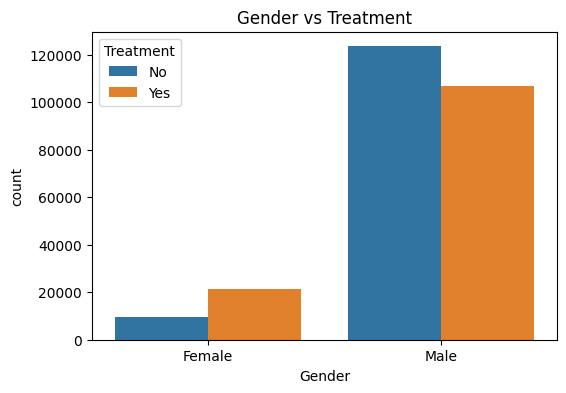

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='Gender', hue='Treatment', data=df)
plt.title("Gender vs Treatment")
plt.show()

In [5]:
#1. XỨ LÝ MISSING VALUES
#Kiểm tra số lượng missing
print("\nSố lượng missing theo cột:")
print(df.isnull().sum())


Số lượng missing theo cột:
Gender                      0
Country                     0
Occupation                  0
SelfEmployed             4356
FamilyHistory               0
Treatment                   0
DaysIndoors                 0
HabitsChange                0
MentalHealthHistory         0
IncreasingStress            0
MoodSwings                  0
SocialWeakness              0
CopingStruggles             0
WorkInterest                0
SocialWeakness.1            0
MentalHealthInterview       0
CareOptions                 0
dtype: int64


Có 1 cột bị missing là SelfEmployed với 4356 giá trị missing

In [6]:
#Điền giá trị thiếu cho cột SelfEmployed
#Điền bằng giá trị phổ biến nhất (mode)
df['SelfEmployed'] = df['SelfEmployed'].fillna(df['SelfEmployed'].mode()[0])

#Kiểm tra sau khi điền dữ liệu
print("\nSố lượng missing sau khi impute:")
print(df.isna().sum())


Số lượng missing sau khi impute:
Gender                   0
Country                  0
Occupation               0
SelfEmployed             0
FamilyHistory            0
Treatment                0
DaysIndoors              0
HabitsChange             0
MentalHealthHistory      0
IncreasingStress         0
MoodSwings               0
SocialWeakness           0
CopingStruggles          0
WorkInterest             0
SocialWeakness.1         0
MentalHealthInterview    0
CareOptions              0
dtype: int64


In [7]:
#2. LOẠI BỎ CỘT
#Có hai cột giống tên SocialWeakness và SocialWeakness.1
#Kiểm tra xem dữ liệu có bị trùng lặp không
(df['SocialWeakness'] == df['SocialWeakness.1']).value_counts()

True    261328
Name: count, dtype: int64

Kết quả trả về là True => dữ liệu bị trùng

In [8]:
#Chọn xóa cột SocialWeakness.1 do dữ liệu trùng lặp
df = df.drop(columns=['SocialWeakness.1'])

#Kiểm tra cột SocialWeakness.1 còn tồn tại không
print('SocialWeakness.1' in df.columns)   # Trả về True/False

False


In [9]:
#3. MÃ HÓA DỮ LIỆU
#3.1 Xử lý các cột Binary bằng Mapping (yes/no -> 1/0)
for col in ['SelfEmployed','FamilyHistory','Treatment','CopingStruggles']:
    df[col] = df[col].map({'No': 0, 'Yes': 1})

df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

#3.2 Xử lý các cột Ordinal bằng Ordinal endcoding
days_map = {'Go out Every day': 0,'1-14 days': 1,'15-30 days': 2, '31-60 days': 3,'More than 2 months': 4}

level_map = {'Low': 0,'Medium': 1,'High': 2}

df['DaysIndoors'] = df['DaysIndoors'].map(days_map)
df['MoodSwings'] = df['MoodSwings'].map(level_map)

#Kiểm tra sau xử lý có còn dữ liệu Nah do lỗi không
print(df[['SelfEmployed','FamilyHistory','Treatment','CopingStruggles', 'Gender','DaysIndoors', 'MoodSwings']].isna().sum())


SelfEmployed       0
FamilyHistory      0
Treatment          0
CopingStruggles    0
Gender             0
DaysIndoors        0
MoodSwings         0
dtype: int64


In [10]:
#3.3 Xử lý các cột còn lại bằng one-hot endcoding
multi_cols = ['MentalHealthHistory','HabitsChange','IncreasingStress',
'SocialWeakness','WorkInterest','MentalHealthInterview','CareOptions']

nominal_cols = ['Country','Occupation']

df = pd.get_dummies(df,columns=multi_cols + nominal_cols,drop_first=True)

In [11]:
#Kiểm tra dữ liệu sao khi đã xử lý xong
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261328 entries, 0 to 261327
Data columns (total 59 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   Gender                          261328 non-null  int64
 1   SelfEmployed                    261328 non-null  int64
 2   FamilyHistory                   261328 non-null  int64
 3   Treatment                       261328 non-null  int64
 4   DaysIndoors                     261328 non-null  int64
 5   MoodSwings                      261328 non-null  int64
 6   CopingStruggles                 261328 non-null  int64
 7   MentalHealthHistory_No          261328 non-null  bool 
 8   MentalHealthHistory_Yes         261328 non-null  bool 
 9   HabitsChange_No                 261328 non-null  bool 
 10  HabitsChange_Yes                261328 non-null  bool 
 11  IncreasingStress_No             261328 non-null  bool 
 12  IncreasingStress_Yes            261328 non-n

,Gender,SelfEmployed,FamilyHistory,Treatment,DaysIndoors,MoodSwings,CopingStruggles,MentalHealthHistory_No,MentalHealthHistory_Yes,HabitsChange_No,...,Country_South Africa,Country_Sweden,Country_Switzerland,Country_Thailand,Country_UK,Country_USA,Occupation_Corporate,Occupation_Housewife,Occupation_Others,Occupation_Student
0,1,0,1,0,2,2,1,False,True,True,...,False,False,False,False,True,False,False,False,True,False
1,1,0,1,0,2,2,1,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,1,0,0,1,4,1,0,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1,0,1,1,0,1,0,False,False,True,...,False,False,False,False,False,False,True,False,False,False
4,1,0,0,1,4,1,0,True,False,False,...,False,False,False,False,True,False,True,False,False,False
5,1,0,0,0,0,2,0,False,True,False,...,False,False,False,False,False,True,False,False,False,True
6,1,0,1,0,1,2,1,False,False,False,...,False,False,False,False,False,True,True,False,False,False
7,1,0,1,1,2,1,1,False,True,False,...,False,False,False,False,False,True,False,True,False,False
8,1,0,1,1,0,1,1,False,False,False,...,False,False,False,False,False,True,False,False,False,True
9,1,0,1,1,1,1,1,False,True,False,...,False,False,False,False,False,True,False,True,False,False


In [12]:
#Chuẩn bị dữ liệu
X = df.drop('Treatment', axis=1)
y = df['Treatment']
#Train 80, Test 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
#XGBOOST
model_xgb = XGBClassifier(
    n_estimators=300,        # số cây
    max_depth=6,             # độ sâu cây
    learning_rate=0.05,      # tốc độ học
    subsample=0.8,           # lấy 80% sample
    colsample_bytree=0.8,    # lấy 80% feature
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

In [14]:
print("----XGBoost----")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

----XGBoost----
Accuracy: 0.7636130562889832
ROC AUC: 0.8513917264964945

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.72      0.76     26592
           1       0.74      0.81      0.77     25674

    accuracy                           0.76     52266
   macro avg       0.77      0.76      0.76     52266
weighted avg       0.77      0.76      0.76     52266



Accuracy (0.7636) → ~76% dự đoán đúng tổng thể, mức khá.

ROC AUC (0.8514) → Khả năng phân biệt 2 lớp tốt, mô hình nhận biết đúng người cần treatment.

Class 0 (không cần treatment)

-Precision: 0.80 → 80% dự đoán đúng.

-Recall: 0.72 → Phát hiện 72% số thực sự lớp 0.

-F1-score: 0.76 → Trung bình giữa precision và recall.

Class 1 (cần treatment)

-Precision: 0.74 → 74% dự đoán đúng.

-Recall: 0.81 → Phát hiện 81% số thực sự lớp 1.

-F1-score: 0.77 → Trung bình giữa precision và recall.

Macro avg → 0.77 (precision), 0.76 (recall), 0.76 (F1) → Trung bình không trọng số.

Weighted avg → 0.77, 0.76, 0.76 → Trung bình theo số lượng mẫu

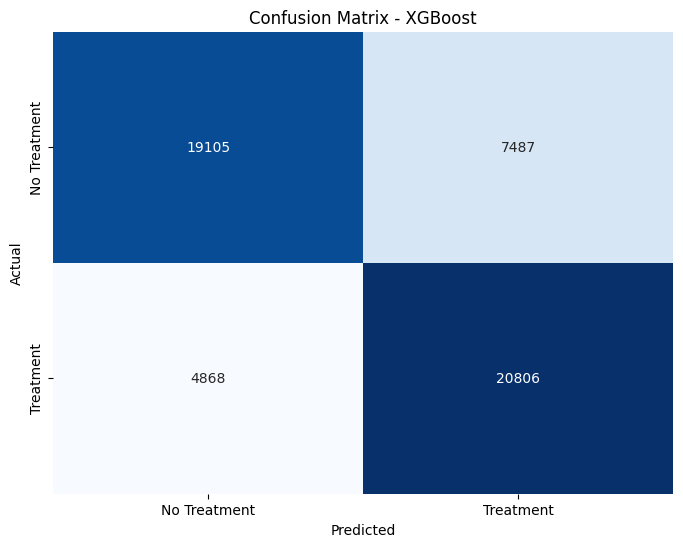

In [15]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb,annot=True,fmt="d",cmap="Blues",cbar=False,
    xticklabels=['No Treatment', 'Treatment'],yticklabels=['No Treatment', 'Treatment'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [16]:
#XGBOOST Tuning
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

xgb_search = RandomizedSearchCV(
    XGBClassifier(objective="binary:logistic",eval_metric="logloss",random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("Best XGB params:", xgb_search.best_params_)
xgb_tuned = xgb_search.best_estimator_

y_pred_xgb_tuned = xgb_tuned.predict(X_test)
y_proba_xgb_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

Best XGB params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [17]:
print("---- XGBoost Tuned ----")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb_tuned))

---- XGBoost Tuned ----
Accuracy: 0.7713044809245015
ROC AUC: 0.8591585337343721

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76     26592
           1       0.74      0.82      0.78     25674

    accuracy                           0.77     52266
   macro avg       0.77      0.77      0.77     52266
weighted avg       0.77      0.77      0.77     52266



Accuracy (0.7713) → ~77%, tăng nhẹ so với phiên bản trước.

ROC AUC (0.8592) → Khả năng phân biệt 2 lớp tốt hơn trước, cải thiện nhận biết người cần treatment.

Class 0 (không cần treatment)

-Precision: 0.81 → 81% dự đoán đúng.

-Recall: 0.72 → Phát hiện 72% số thực sự lớp 0.

-F1-score: 0.76 → Trung bình tốt.

Class 1 (cần treatment)

-Precision: 0.74 → 74% dự đoán đúng.

-Recall: 0.82 → Phát hiện 82% số thực sự lớp 1 (tăng so với 81% trước).

-F1-score: 0.78 → Cải thiện nhẹ.

Macro avg → 0.77 (precision), 0.77 (recall), 0.77 (F1) → Trung bình cân đối hơn.

Weighted avg → 0.77, 0.77, 0.77 → Trung bình theo số lượng mẫu.

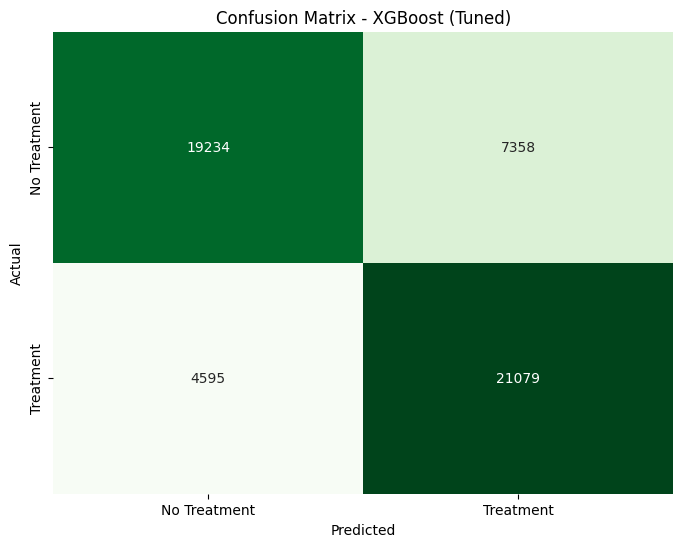

In [18]:
cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_xgb_tuned,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=False,
    xticklabels=['No Treatment', 'Treatment'],
    yticklabels=['No Treatment', 'Treatment']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost (Tuned)')
plt.show()

In [19]:
print("=== Accuracy Comparison ===")
print(f"XGBoost Baseline Accuracy : {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost Tuned Accuracy    : {accuracy_score(y_test, y_pred_xgb_tuned):.4f}")

=== Accuracy Comparison ===
XGBoost Baseline Accuracy : 0.7636
XGBoost Tuned Accuracy    : 0.7713


Accuracy tăng từ 0.7636 → 0.7713, cải thiện nhỏ nhưng có ý nghĩa; tuning giúp mô hình tốt hơn, nhưng mức tăng không quá lớn.

In [20]:
#LIGHTGBM
model_lgb = lgb.LGBMClassifier(
    n_estimators=300,          # Số lượng cây 
    learning_rate=0.05,        # Tốc độ học 
    max_depth=-1,               # Chiều sâu tối đa của mỗi cây
    num_leaves=31,              # Số lá tối đa của mỗi cây
    subsample=0.8,              # Lấy 80% mẫu dữ liệu ngẫu nhiên 
    colsample_bytree=0.8,       # Lấy 80% đặc trưng (features) ngẫu nhiên
    objective='binary',         # Mục tiêu bài toán: phân loại nhị phân (binary classification).
    random_state=42             
)

model_lgb.fit(X_train, y_train)
y_pred_lgb = model_lgb.predict(X_test)
y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 102696, number of negative: 106366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 209062, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491223 -> initscore=-0.035113
[LightGBM] [Info] Start training from score -0.035113


In [21]:
print("----LigthGBM----")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))

----LigthGBM----
Accuracy: 0.7753032564190869
ROC AUC: 0.8640275252009669

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.77     26592
           1       0.74      0.83      0.78     25674

    accuracy                           0.78     52266
   macro avg       0.78      0.78      0.77     52266
weighted avg       0.78      0.78      0.77     52266



Accuracy (0.7753) → ~77.5%, tăng nhẹ so với XGBoost tuned.

ROC AUC (0.8640) → Khả năng phân biệt 2 lớp tốt, cải thiện nhận biết người cần treatment.


Class 0 (không cần treatment)

-Precision: 0.81 → 81% dự đoán đúng.

-Recall: 0.72 → Phát hiện 72% số thực sự lớp 0.

-F1-score: 0.77 → Trung bình tốt.

Class 1 (cần treatment)

-Precision: 0.74 → 74% dự đoán đúng.

-Recall: 0.83 → Phát hiện 83% số thực sự lớp 1, cải thiện so với lớp 0.

-F1-score: 0.78 → Cân bằng và tốt.

Macro avg → 0.78 (precision), 0.78 (recall), 0.77 (F1) → Trung bình cân đối.

Weighted avg → 0.78, 0.78, 0.77 → Trung bình theo số lượng mẫu.

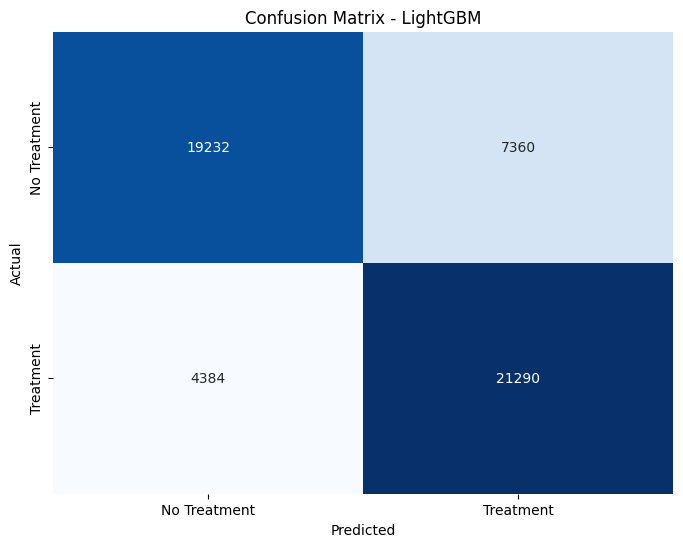

In [22]:
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_lgb,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=['No Treatment', 'Treatment'],
    yticklabels=['No Treatment', 'Treatment']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LightGBM')
plt.show()


In [23]:
# LIGHTGBM tuning
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [15, 31, 63, 127],
    "max_depth": [-1, 3, 5, 7, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

lgb_search = RandomizedSearchCV(
    LGBMClassifier(
        objective="binary",
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

lgb_search.fit(X_train, y_train)

print("Best LightGBM parameters:")
print(lgb_search.best_params_)
lgb_tuned = lgb_search.best_estimator_

y_pred_lgb_tuned = lgb_tuned.predict(X_test)
y_proba_lgb_tuned = lgb_tuned.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 102696, number of negative: 106366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 209062, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491223 -> initscore=-0.035113
[LightGBM] [Info] Start training from score -0.035113
Best LightGBM parameters:
{'subsample': 0.7, 'num_leaves': 63, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


In [24]:
print("---- LightGBM Tuned ----")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lgb_tuned))
print("\nClassification Report:\n",classification_report(y_test, y_pred_lgb_tuned))

---- LightGBM Tuned ----
Accuracy: 0.775992040714805
ROC AUC: 0.865218616595971

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77     26592
           1       0.74      0.84      0.79     25674

    accuracy                           0.78     52266
   macro avg       0.78      0.78      0.78     52266
weighted avg       0.78      0.78      0.78     52266



Accuracy (0.7760) → ~77.6%, tăng nhẹ so với phiên bản trước.

ROC AUC (0.8652) → Khả năng phân biệt 2 lớp tốt hơn, cải thiện nhận biết người cần treatment.

Class 0 (không cần treatment)

-Precision: 0.82 → 82% dự đoán đúng.

-Recall: 0.72 → Phát hiện 72% số thực sự lớp 0.

-F1-score: 0.77 → Trung bình tốt.

Class 1 (cần treatment)

-Precision: 0.74 → 74% dự đoán đúng.

-Recall: 0.84 → Phát hiện 84% số thực sự lớp 1, cải thiện so với phiên bản trước.

-F1-score: 0.79 → Cải thiện nhẹ, cân bằng hơn.

Macro avg → 0.78 (precision), 0.78 (recall), 0.78 (F1) → Trung bình cân đối.

Weighted avg → 0.78, 0.78, 0.78 → Trung bình theo số lượng mẫu.

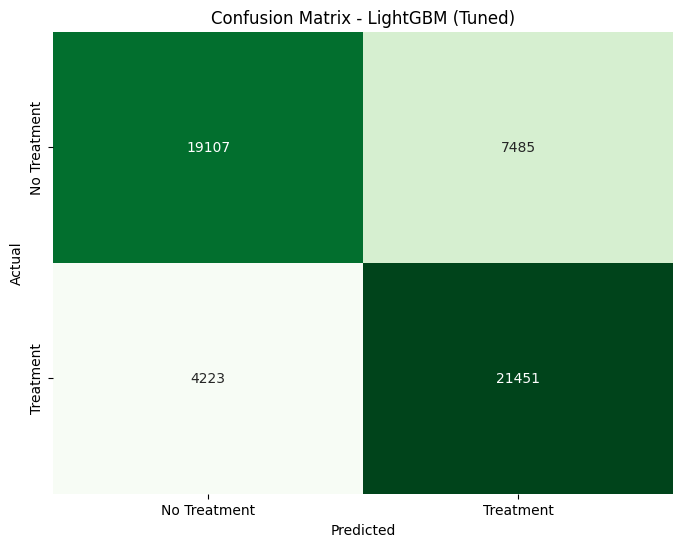

In [25]:
cm_lgb_tuned = confusion_matrix(y_test, y_pred_lgb_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_lgb_tuned,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=False,
    xticklabels=['No Treatment', 'Treatment'],
    yticklabels=['No Treatment', 'Treatment']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LightGBM (Tuned)')
plt.show()

In [26]:
print("=== LightGBM Comparison ===")
print(f"Baseline Accuracy : {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"Tuned Accuracy    : {accuracy_score(y_test, y_pred_lgb_tuned):.4f}")


=== LightGBM Comparison ===
Baseline Accuracy : 0.7753
Tuned Accuracy    : 0.7760


Tuning cải thiện hiệu suất nhẹ, mô hình vẫn giữ khả năng phân biệt 2 lớp tốt.

In [27]:
#RANDOM FOREST
rf_base = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

rf_base.fit(X_train, y_train)
y_pred_rf_base = rf_base.predict(X_test)
y_proba_rf_base = rf_base.predict_proba(X_test)[:, 1]

In [28]:
print("---- Random Forest BASELINE ----")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_base))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf_base))
print("\nClassification Report:\n",classification_report(y_test, y_pred_rf_base))

---- Random Forest BASELINE ----
Accuracy: 0.7354111659587494
ROC AUC: 0.799025967497495

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73     26592
           1       0.72      0.77      0.74     25674

    accuracy                           0.74     52266
   macro avg       0.74      0.74      0.74     52266
weighted avg       0.74      0.74      0.74     52266



Accuracy (0.7354) → ~73.5%, hiệu suất tổng thể chưa cao.

ROC AUC (0.7990) → Khả năng phân biệt 2 lớp khá

Class 0 (không cần treatment)

-Precision: 0.76 → 76% dự đoán đúng.

-Recall: 0.71 → Phát hiện 71% số thực sự lớp 0.

-F1-score: 0.73 → Trung bình, chưa cao.

Class 1 (cần treatment)

-Precision: 0.72 → 72% dự đoán đúng.

-Recall: 0.77 → Phát hiện 77% số thực sự lớp 1.

-F1-score: 0.74 → Trung bình.

Macro avg → 0.74 (precision), 0.74 (recall), 0.74 (F1) → Trung bình cân đối 

Weighted avg → 0.74, 0.74, 0.74 → Trung bình theo số lượng mẫu.

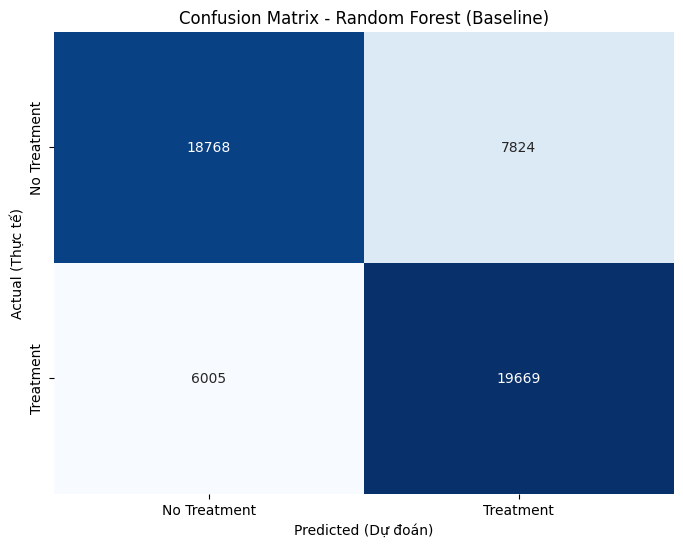

In [29]:
cm_rf_base = confusion_matrix(y_test, y_pred_rf_base)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf_base,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=['No Treatment', 'Treatment'],
    yticklabels=['No Treatment', 'Treatment']
)

plt.xlabel('Predicted (Dự đoán)')
plt.ylabel('Actual (Thực tế)')
plt.title('Confusion Matrix - Random Forest (Baseline)')
plt.show()

In [30]:
# --- RANDOM FOREST ---
param_dist_rf = {
    "n_estimators": [50, 100, 200, 300],       # Số lượng cây
    "max_depth": [None, 10, 20, 30],           # Độ sâu tối đa của cây
    "min_samples_split": [2, 5, 10],           # Số mẫu tối thiểu để tách nhánh
    "min_samples_leaf": [1, 2, 4],             # Số mẫu tối thiểu ở lá
    "bootstrap": [True, False]                 # Phương pháp lấy mẫu
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=5,        # Thử ngẫu nhiên 5 tổ hợp (để chạy cho nhanh)
    cv=3,             # Chia dữ liệu làm 3 phần để kiểm tra chéo
    scoring="accuracy", # Ưu tiên độ chính xác
    random_state=42,
    n_jobs=-1         # Dùng 100% công suất CPU
)

# Bắt đầu huấn luyện
rf_search.fit(X_train, y_train)

print(f"Tham số tốt nhất là: {rf_search.best_params_}")
best_rf = rf_search.best_estimator_

# Dự đoán trên tập Test bằng mô hình tốt nhất
y_pred_rf_tuned = best_rf.predict(X_test)
y_proba_rf_tuned = best_rf.predict_proba(X_test)[:, 1]

Tham số tốt nhất là: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}


In [31]:
print("----RANDOM FOREST TUNED ----")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_tuned))

----RANDOM FOREST TUNED ----
Accuracy: 0.7414954272375923
ROC AUC: 0.8221069715289279

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.74     26592
           1       0.72      0.77      0.75     25674

    accuracy                           0.74     52266
   macro avg       0.74      0.74      0.74     52266
weighted avg       0.74      0.74      0.74     52266



Accuracy (0.7415) → ~74.1%, tăng nhẹ so với baseline.

ROC AUC (0.8221) → Khả năng phân biệt 2 lớp tốt hơn, cải thiện nhận biết người cần treatment.

Class 0 (không cần treatment)

-Precision: 0.76 → 76% dự đoán đúng.

-Recall: 0.71 → Phát hiện 71% số thực sự lớp 0.

-F1-score: 0.74 → Cải thiện nhẹ so với baseline.

Class 1 (cần treatment)

-Precision: 0.72 → 72% dự đoán đúng.

-Recall: 0.77 → Phát hiện 77% số thực sự lớp 1.

-F1-score: 0.75 → Cải thiện nhẹ.

Macro avg → 0.74 (precision), 0.74 (recall), 0.74 (F1) → Trung bình cân đối.

Weighted avg → 0.74, 0.74, 0.74 → Trung bình theo số lượng mẫu.

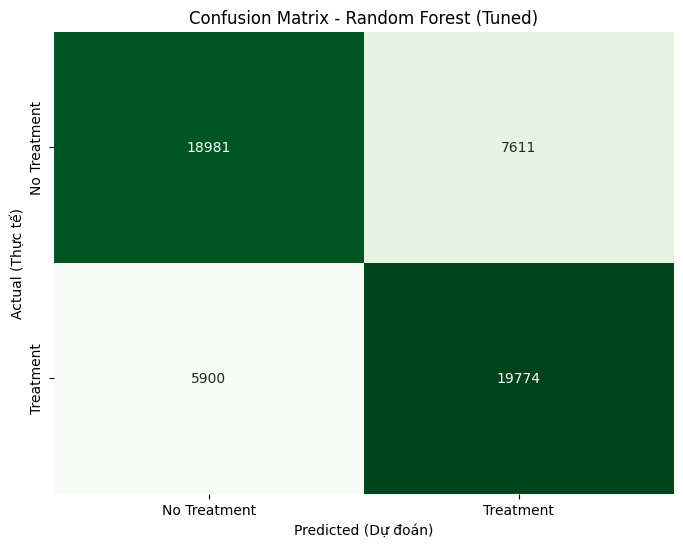

In [32]:
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf_tuned,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=False,
    xticklabels=['No Treatment', 'Treatment'],
    yticklabels=['No Treatment', 'Treatment']
)

plt.xlabel('Predicted (Dự đoán)')
plt.ylabel('Actual (Thực tế)')
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.show()

In [33]:
print("---- Random Forest ----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_base):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}")

---- Random Forest ----
Accuracy: 0.7354
Accuracy: 0.7415


Tuning giúp mô hình cải thiện hiệu suất một chút

In [34]:
# --- NAIVE BAYES ---
# Khởi tạo mô hình
nb_model = GaussianNB()
# Bắt đầu huấn luyện
nb_model.fit(X_train, y_train)
# Dự đoán
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]

In [35]:
print("----NAIVE BAYES----")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

----NAIVE BAYES----
Accuracy: 0.5381318639268358
ROC AUC: 0.5461040914560771

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.09      0.17     26592
           1       0.52      1.00      0.68     25674

    accuracy                           0.54     52266
   macro avg       0.76      0.55      0.42     52266
weighted avg       0.76      0.54      0.42     52266



Accuracy (0.5381) → ~53.8%, thấp, hiệu suất tổng thể kém.

ROC AUC (0.5461) → Khả năng phân biệt 2 lớp gần như yếu, gần 0.5.

Class 0 (không cần treatment)

-Precision: 1.00 → 100% dự đoán đúng, nhưng chỉ dự đoán ít trường hợp.

-Recall: 0.09 → Chỉ phát hiện 9% số thực sự lớp 0, rất thấp.

-F1-score: 0.17 → Rất kém.

Class 1 (cần treatment)

-Precision: 0.52 → 52% dự đoán đúng.

-Recall: 1.00 → Phát hiện 100% số thực sự lớp 1, nhưng đánh đổi với class 0.

-F1-score: 0.68 → Chênh lệch lớn, không cân bằng.

Macro avg → 0.76 (precision), 0.55 (recall), 0.42 (F1) → Trung bình lệch nhiều.

Weighted avg → 0.76, 0.54, 0.42 → Trung bình theo số lượng mẫu.

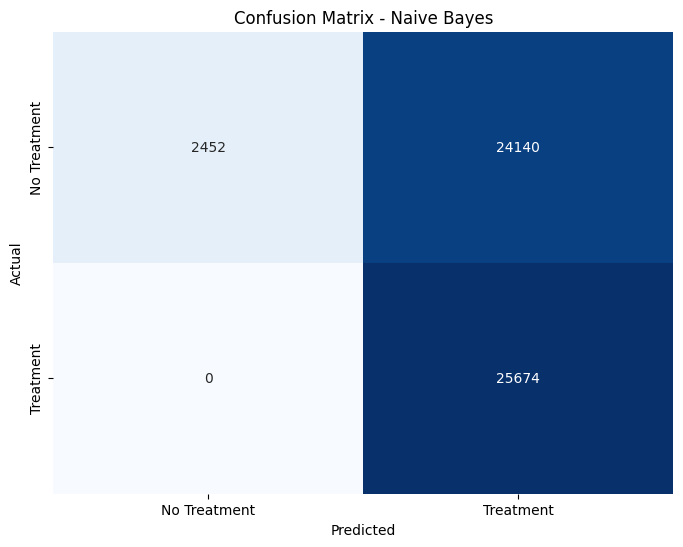

In [36]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Treatment', 'Treatment'],
            yticklabels=['No Treatment', 'Treatment'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Khởi tạo model base
nb_model = GaussianNB()

# GridSearchCV để tuning var_smoothing
param_grid = {"var_smoothing": [1e-12, 1e-10, 1e-9, 1e-8, 1e-7]}

grid_nb = GridSearchCV(nb_model, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_nb.fit(X_train, y_train)


print("Best params:", grid_nb.best_params_)
nb_tuned = grid_nb.best_estimator_

# Dự đoán
y_pred_nb_tuned = nb_tuned.predict(X_test)
y_proba_nb_tuned = nb_tuned.predict_proba(X_test)[:, 1]


Best params: {'var_smoothing': 1e-08}


In [38]:
print("----NAIVE BAYES TUNED----")
print("Accuracy:", accuracy_score(y_test, y_pred_nb_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_proba_nb_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb_tuned))

----NAIVE BAYES TUNED----
Accuracy: 0.5381318639268358
ROC AUC: 0.5580177466349574

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.09      0.17     26592
           1       0.52      1.00      0.68     25674

    accuracy                           0.54     52266
   macro avg       0.76      0.55      0.42     52266
weighted avg       0.76      0.54      0.42     52266



Accuracy (0.5381) → ~53.8%, thấp, hiệu suất tổng thể kém.

ROC AUC (0.5461) → Khả năng phân biệt 2 lớp gần như yếu, gần 0.5.

Class 0 (không cần treatment)

-Precision: 1.00 → 100% dự đoán đúng, nhưng chỉ dự đoán ít trường hợp.

-Recall: 0.09 → Chỉ phát hiện 9% số thực sự lớp 0, rất thấp.

-F1-score: 0.17 → Rất kém.

Class 1 (cần treatment)

-Precision: 0.52 → 52% dự đoán đúng.

-Recall: 1.00 → Phát hiện 100% số thực sự lớp 1, nhưng đánh đổi với class 0.

-F1-score: 0.68 → Chênh lệch lớn, không cân bằng.

Macro avg → 0.76 (precision), 0.55 (recall), 0.42 (F1) → Trung bình lệch nhiều.

Weighted avg → 0.76, 0.54, 0.42 → Trung bình theo số lượng mẫu.

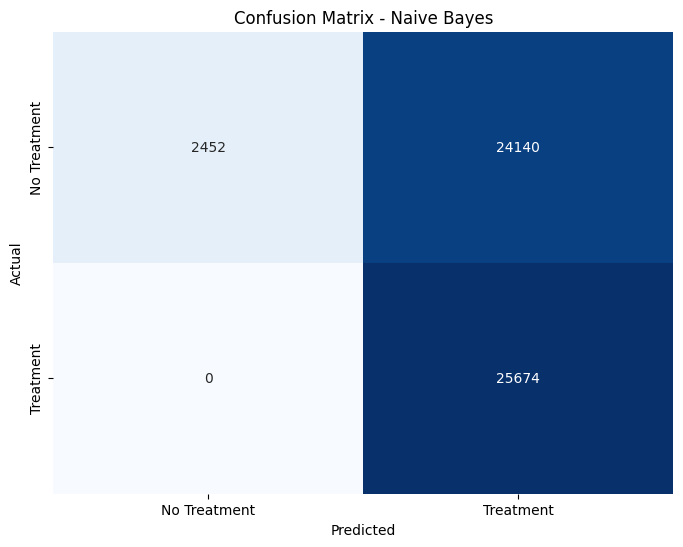

In [39]:
cm_nb_tuned = confusion_matrix(y_test, y_pred_nb_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb_tuned, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Treatment', 'Treatment'],
            yticklabels=['No Treatment', 'Treatment'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [40]:
print("---- Navies Bayes ----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb_tuned):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb_tuned):.4f}")

---- Navies Bayes ----
Accuracy: 0.5381
Accuracy: 0.5381


Tuning Naive Bayes trên dữ liệu này gần như vô tác dụng

In [41]:
# DT
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

In [42]:
acc_dt = accuracy_score(y_test, y_pred_dt)
print("----Decision Tree----")
print("Accuracy:", acc_dt)
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))
print(classification_report(y_test, y_pred_dt))

----Decision Tree----
Accuracy: 0.7236444342402326
ROC AUC: 0.7934088402657142
              precision    recall  f1-score   support

           0       0.73      0.72      0.73     26592
           1       0.72      0.72      0.72     25674

    accuracy                           0.72     52266
   macro avg       0.72      0.72      0.72     52266
weighted avg       0.72      0.72      0.72     52266



Accuracy (0.7236) → ~72.4%, thấp hơn Random Forest

ROC AUC (0.7934) → Khả năng phân biệt 2 lớp khá

Class 0 (không cần treatment)

-Precision: 0.73 → 73% dự đoán đúng.

-Recall: 0.72 → Phát hiện 72% số thực sự lớp 0.

-F1-score: 0.73 → Trung bình.

Class 1 (cần treatment)

-Precision: 0.72 → 72% dự đoán đúng.

-Recall: 0.72 → Phát hiện 72% số thực sự lớp 1.

-F1-score: 0.72 → Trung bình, cân đối.

Macro avg → 0.72 (precision), 0.72 (recall), 0.72 (F1) → Cân đối giữa 2 lớp.

Weighted avg → 0.72, 0.72, 0.72 → Trung bình theo số lượng mẫu.

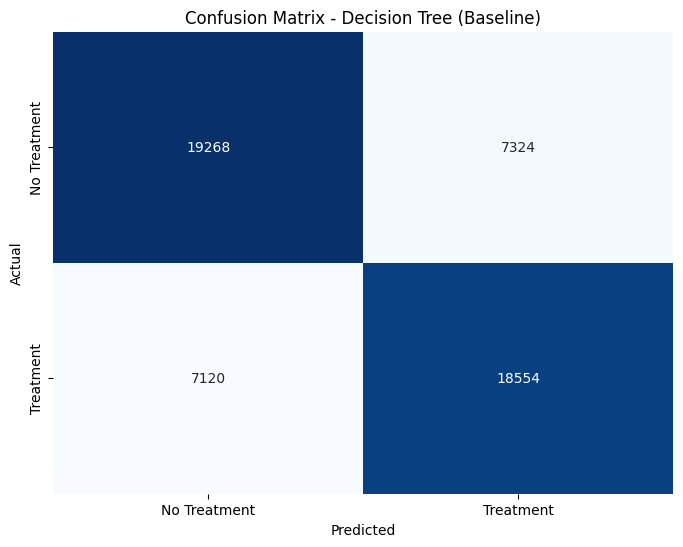

In [43]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_dt,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=['No Treatment', 'Treatment'],
    yticklabels=['No Treatment', 'Treatment']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (Baseline)')
plt.show()

In [44]:
param_dist = {
    "max_depth": [None, 3, 5, 7, 10, 15],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 5, 10, 20],
    "criterion": ["gini", "entropy"]
}

dt_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

dt_search.fit(X_train, y_train)

print("Best parameters:", dt_search.best_params_)
dt_tuned = dt_search.best_estimator_

y_pred_dt_tuned = dt_tuned.predict(X_test)
y_proba_dt_tuned = dt_tuned.predict_proba(X_test)[:, 1]

Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15, 'criterion': 'entropy'}


In [45]:
print("----Decision Tree Tuned----")
print("Accuracy (DT Tuned):", accuracy_score(y_test, y_pred_dt_tuned))
print("ROC AUC (DT Tuned):", roc_auc_score(y_test, y_proba_dt_tuned))
print(classification_report(y_test, y_pred_dt_tuned))

----Decision Tree Tuned----
Accuracy (DT Tuned): 0.7676500975777752
ROC AUC (DT Tuned): 0.8463079202393016
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     26592
           1       0.74      0.82      0.78     25674

    accuracy                           0.77     52266
   macro avg       0.77      0.77      0.77     52266
weighted avg       0.77      0.77      0.77     52266



Accuracy (0.7677) → ~76.8%, cải thiện đáng kể

ROC AUC (0.8463) → Khả năng phân biệt 2 lớp tốt

Class 0 (không cần treatment)

-Precision: 0.80 → 80% dự đoán đúng.

-Recall: 0.72 → Phát hiện 72% số thực sự lớp 0.

-F1-score: 0.76 → Trung bình tốt.

Class 1 (cần treatment)

-Precision: 0.74 → 74% dự đoán đúng.

-Recall: 0.82 → Phát hiện 82% số thực sự lớp 1.

-F1-score: 0.78 → Cân bằng và khá tốt.

Macro avg → 0.77 (precision), 0.77 (recall), 0.77 (F1) → Trung bình cân đối.

Weighted avg → 0.77, 0.77, 0.77 → Trung bình theo số lượng mẫu.

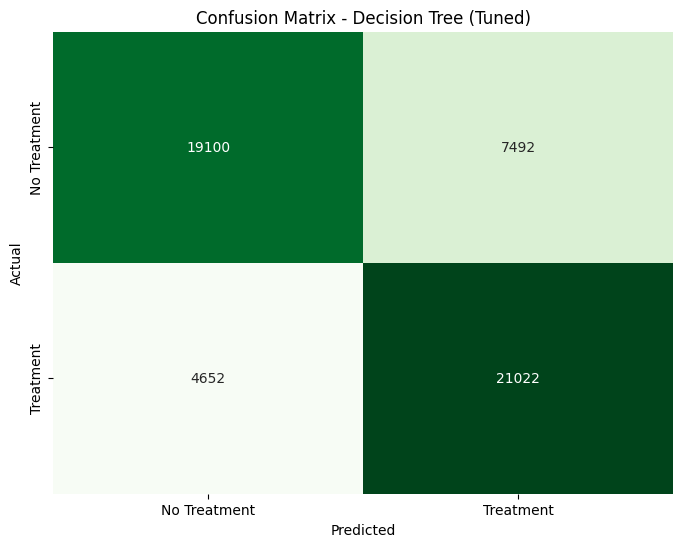

In [46]:
cm_dt_tuned = confusion_matrix(y_test, y_pred_dt_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_dt_tuned,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=False,
    xticklabels=['No Treatment', 'Treatment'],
    yticklabels=['No Treatment', 'Treatment']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (Tuned)')
plt.show()

In [47]:
print('----Decision Tree----')
print("DT baseline accuracy:", acc_dt)
print("DT tuned accuracy:", accuracy_score(y_test, y_pred_dt_tuned))

----Decision Tree----
DT baseline accuracy: 0.7236444342402326
DT tuned accuracy: 0.7676500975777752


Tuning giúp Decision Tree cải thiện hiệu suất rõ rệt

In [48]:
# 5 thuat toan
print("=== Model Accuracy Comparison ===")
print(f"Decision Tree Accuracy : {accuracy_score(y_test, y_pred_dt_tuned):.4f}")
print(f"Random Forest Accuracy : {accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Naive Bayes Accuracy   : {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"LightGBM Accuracy      : {accuracy_score(y_test, y_pred_lgb_tuned):.4f}")
print(f"XGBoost Accuracy       : {accuracy_score(y_test, y_pred_xgb_tuned):.4f}")


=== Model Accuracy Comparison ===
Decision Tree Accuracy : 0.7677
Random Forest Accuracy : 0.7415
Naive Bayes Accuracy   : 0.5381
LightGBM Accuracy      : 0.7760
XGBoost Accuracy       : 0.7713


Boosting (LightGBM, XGBoost) mang lại hiệu suất cao nhấ

Decision Tree tuned cải thiện đáng kể; Random Forest ổn nhưng kém hơn

Naive Bayes kém nhất.

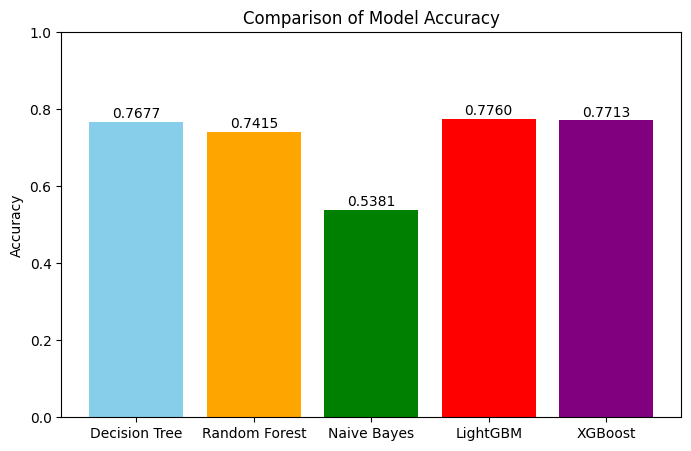

In [49]:
#Vẽ biểu đồ so sánh
models = ['Decision Tree', 'Random Forest', 'Naive Bayes', 'LightGBM', 'XGBoost']
accuracy = [
    accuracy_score(y_test, y_pred_dt_tuned),
    accuracy_score(y_test, y_pred_rf_tuned),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_lgb_tuned),
    accuracy_score(y_test, y_pred_xgb_tuned)
]

plt.figure(figsize=(8,5))
plt.bar(models, accuracy, color=['skyblue','orange','green','red','purple'])
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
for i, v in enumerate(accuracy):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()
